In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from typing import Tuple

In [12]:
def load_cil(dataset="split") -> Tuple[pd.DataFrame, pd.DataFrame, int, int]:
    """Load CIL dataset

    Args:
        dataset : "train", "test" or "split"

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, int, int]: train_data, val_data, user_num, movie_num
    """
    file = "data_train" if dataset != "test" else "sampleSubmission"
    data = pd.read_csv(f'../../delivery/data/{file}.csv', index_col=0)
    data['user'] = data.index.str.split('_').str[0].str[1:].astype('int32')
    data['movie'] = data.index.str.split('_').str[1].str[1:].astype('int32')
    data.rename(columns={'Prediction': 'rating'}, inplace=True)
    data['rating'] = data['rating'].astype('uint8')
    data = data[['user', 'movie', 'rating']]

    data['user'] = data['user']
    data['movie'] = data['movie']

    user_num = 10000 
    movie_num = 1000 
    print("User num: {}, Movie num: {}".format(user_num, movie_num))

    train_data = val_data = None
    if dataset == "test":
        val_data = data
    elif dataset == "train":
        train_data = data
    else:
        train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

    return train_data, val_data, user_num, movie_num

In [13]:
train_data, val_data, user_num, movie_num = load_cil("split")

User num: 10000, Movie num: 1000


### Read the predictions from the individual models to train the ensemble method

In [14]:
dataset = "val"
features = ["predictions_bfm_ppf", "predictions_bfm", "predictions_knn", "predictions_mlp", "predictions_ncf", "similarity_knn", "std_bfm"]

for feature in features:
    feature_df = pd.read_csv(f"../../delivery/ensemble/{feature}_{dataset}.csv", index_col=0)
    val_data[feature] = feature_df.iloc[:, 0]


In [15]:
# get sparsity for each user and movie id in the val set according to the train set
val_data['user_sparsity'] = val_data['user'].map(train_data.groupby('user')['user'].count())
val_data['movie_sparsity'] = val_data['movie'].map(train_data.groupby('movie')['movie'].count())
features.append('user_sparsity')
features.append('movie_sparsity')

In [16]:
print(val_data.head())

            user  movie  rating  predictions_bfm_ppf  predictions_bfm   
Id                                                                      
r5062_c706  5062    706       2             3.562892         3.457201  \
r9044_c148  9044    148       4             3.944348         3.957705   
r1736_c169  1736    169       4             4.054189         4.152227   
r5270_c877  5270    877       1             3.869830         3.837557   
r6100_c691  6100    691       4             3.750074         3.787237   

            predictions_knn  predictions_mlp  predictions_ncf  similarity_knn   
Id                                                                              
r5062_c706         3.450599         3.521483         3.712618        0.026031  \
r9044_c148         4.058141         4.340946         4.044386        0.037758   
r1736_c169         4.497718         4.408668         4.196273        0.032954   
r5270_c877         3.470415         3.608752         3.599608        0.031948   
r6

### Individually trained models scores

In [17]:
from sklearn.metrics import mean_squared_error
# rmse of individual model
rmse_mlp = mean_squared_error(val_data['rating'], val_data['predictions_mlp'], squared=False)
rmse_ncf = mean_squared_error(val_data['rating'], val_data['predictions_ncf'], squared=False)
rmse_bfm = mean_squared_error(val_data['rating'], val_data['predictions_bfm'], squared=False)
rmse_bfm_ppf = mean_squared_error(val_data['rating'], val_data['predictions_bfm_ppf'], squared=False)
rmse_knn = mean_squared_error(val_data['rating'], val_data['predictions_knn'], squared=False)

# print in ascending order
print("RMSE of KNN: {}".format(rmse_knn))
print("RMSE of MLP: {}".format(rmse_mlp))
print("RMSE of NCF: {}".format(rmse_ncf))
print("RMSE of BFM: {}".format(rmse_bfm))
print("RMSE of BFM PPF: {}".format(rmse_bfm_ppf))

RMSE of KNN: 0.9925058600964632
RMSE of MLP: 0.9884040526196102
RMSE of NCF: 0.9880463397744673
RMSE of BFM: 0.9797415528913666
RMSE of BFM PPF: 0.9729213399919445


# First Ensemble Model : XGBoost

In [18]:
# split val data into train and val
train_data_ensemble, val_data_ensemble = train_test_split(val_data, test_size=0.2, random_state=42)

In [19]:
# train random forest regression model
from sklearn.ensemble import GradientBoostingClassifier

rf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.009, max_depth=5)
rf.fit(train_data_ensemble[features], train_data_ensemble['rating'])

In [ ]:
preds = rf.predict(val_data_ensemble[features])
preds = np.clip(preds, 1, 5)
print("RMSE: {}".format(mean_squared_error(val_data_ensemble['rating'], preds, squared=False)))

RMSE: 0.9726835966600276


# Second Ensemble Model : Linear Regression

## Training

In [ ]:
# now train linear regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_data_ensemble[features[:5]], train_data_ensemble['rating'])

LinearRegression()

In [ ]:
preds = lr.predict(val_data_ensemble[features[:5]])
preds = np.clip(preds, 1, 5)
print("RMSE: {}".format(mean_squared_error(val_data_ensemble['rating'], preds, squared=False)))

RMSE: 0.9718315692455486


## Vizualisation of features importance

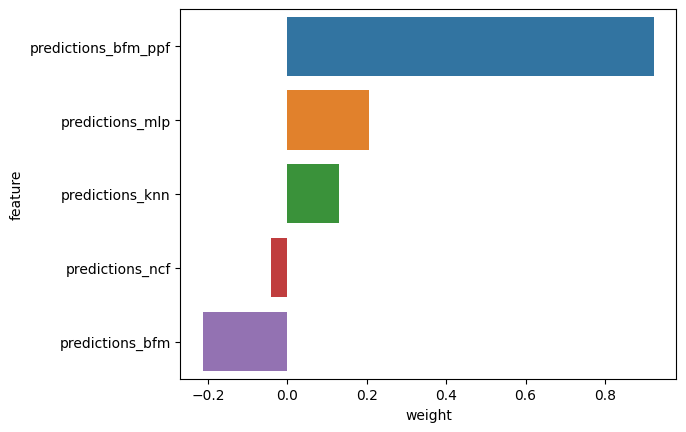

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# print feature importance
feature_importance = pd.DataFrame({'feature': features[:5], 'weight': lr.coef_})
feature_importance = feature_importance.sort_values(by='weight', ascending=False)
sns.barplot(x='weight', y='feature', data=feature_importance)
plt.show()

## Comparison with individual models

In [ ]:
# rmse of individual model
rmse_mlp = mean_squared_error(val_data_ensemble['rating'], val_data_ensemble['predictions_mlp'], squared=False)
rmse_ncf = mean_squared_error(val_data_ensemble['rating'], val_data_ensemble['predictions_ncf'], squared=False)
rmse_bfm = mean_squared_error(val_data_ensemble['rating'], val_data_ensemble['predictions_bfm'], squared=False)
rmse_bfm_ppf = mean_squared_error(val_data_ensemble['rating'], val_data_ensemble['predictions_bfm_ppf'], squared=False)
rmse_knn = mean_squared_error(val_data_ensemble['rating'], val_data_ensemble['predictions_knn'], squared=False)

# print in ascending order
print("RMSE of KNN: {}".format(rmse_knn))
print("RMSE of MLP: {}".format(rmse_mlp))
print("RMSE of NCF: {}".format(rmse_ncf))
print("RMSE of BFM: {}".format(rmse_bfm))
print("RMSE of BFM PPF: {}".format(rmse_bfm_ppf))
print("-------")
print("RMSE of ENSEMBLE: {}".format(mean_squared_error(val_data_ensemble['rating'], preds, squared=False)))

RMSE of KNN: 0.9920871743261326
RMSE of MLP: 0.98850980465946
RMSE of NCF: 0.9876908165859187
RMSE of BFM: 0.9795274627045788
RMSE of BFM PPF: 0.9731937332002116
-------
RMSE of ENSEMBLE: 0.9718315692455486


# Final Submission File

In [ ]:
# Load test data
_, test_data, user_num, movie_num = load_cil("test")

User num: 10000, Movie num: 1000


In [ ]:
dataset = "test"
features = ["predictions_bfm_ppf", "predictions_bfm", "predictions_knn", "predictions_mlp", "predictions_ncf"]

for feature in features:
    feature_df = pd.read_csv(f"../../delivery/ensemble/{feature}_{dataset}.csv", index_col=0)
    test_data[feature] = np.clip(feature_df.iloc[:, 0], 1, 5)

In [ ]:
display(test_data.head())

,user,movie,rating,predictions_bfm_ppf,predictions_bfm,predictions_knn,predictions_mlp,predictions_ncf
Id,,,,,,,,
r37_c1,37,1,3,3.279221,3.271470,3.187437,3.438433,3.255605
r73_c1,73,1,3,3.332236,3.115413,3.071045,3.047700,2.917824
r156_c1,156,1,3,3.826852,3.740160,3.817712,3.749494,3.844527
r160_c1,160,1,3,3.496139,3.313910,3.059693,3.210039,3.173617
r248_c1,248,1,3,3.520885,3.537277,3.370848,3.535636,3.615509


In [ ]:
preds = lr.predict(test_data[features[:5]])
preds = np.clip(preds, 1, 5)
test_data['Prediction'] = preds

In [ ]:
test_data['Prediction'].to_csv(f"../../delivery/outputs/ensemble/predictions_ensemble_test.csv")